<a href="https://colab.research.google.com/github/IrisFDTD/PINNs-for-education/blob/main/3rd_order_nonlinear_ODE_PINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Physics-Informed Neural Networks - 3rd order Ordinary Differential Equations

+ This notebook has been implemented by Jorge Paz-Peñuelas Oliván (774270@unizar.es) as part of extracurricular activities at the University of Zaragoza in July 2023.
+ The code builds upon the 2nd-order ODE implementation using Physics-Informed Neural Networks (PINNs) done by Luis Medrano.Navarro, Luis Martin Moreno and Sergio G Rodrigo ([Solving differential equations in physics with Deep Learning: a beginner’s guide](https://arxiv.org/abs/2307.11237)).


## Important libraries

In [ ]:
# Tensorflow Keras and rest of the packages
import tensorflow as tf
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.optimizers import Adam,SGD
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6,4.5)
import types

2023-08-01 19:57:10.398533: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Definition of the ODE

An arbitrary Ordinary Differential Equation (ODE) of $n$-order for a function $y:\mathbb{R}\to\mathbb{R}$ with variable $x$ can be written as follows
$$F\left(x,y,y',y'',\dots,y^{(n)}\right)=0$$

To determine a unique solution it is necessary to provide the initial conditions.
$$y(x_0)\quad y'(x_0)\quad\dots\quad y^{(n-1)}(x_0)$$

As we are going to be programming arbitrary differential equations we also want to solve them with the usual RK4 algortihm to be able to compare the final solutions. RK4 has the limitation of needing to write the equation as an order one system of differential equations $Y'=H(x,Y)$.

Thus we will first consider equations of the form
$$y^{(n)}=G\left(x,y,y',\dots,y^{(n-1)}\right)$$
where the corresponding $F$ would be $F=y^{(n)}-G$

Firstly we have to write the $n$-th order equation as a system of first order equations. Let $Y:\mathbb{R}\to\mathbb{R}^n$ with $Y=(y_1,y_2,\dots,y_n)^T=(y,y',\dots,y^{(n-1)})^T$ such that $Y'=H(x,Y)$ with $H:\mathbb{R}\times\mathbb{R}^n\to\mathbb{R}^n$ given by
$$H(x,Y)=\begin{pmatrix}y_2\\\vdots\\y_n\\G(x,Y)\end{pmatrix}$$
In our case $n\le3$.

To generalise and to simplify the definition of functions $G,F$ and $H$ we will denote by $\tilde{Y}=(Y^T,y^{(n)})^T$

As an example we are going to be studying the equation
$$y'''-y'\sin(y)+y''y=0$$
with initial conditions $y(0)=-\frac{1}{2}$, $y'(0)=0$ and $y''(0)=1$

In [ ]:
# Info on the ODE

SolveMedrano = False  # Medrano's 2nd order ODE

Order = 3
RKsolvable = True

if SolveMedrano:
    Order = 2
    RKsolvable = True


    # We define the ODE

if RKsolvable:
    def ode_G(x,Y, coefs=None):
        if SolveMedrano: return Y[0]+3*Y[0]**2
        else: return Y[1]*tf.math.sin(Y[0])-Y[2]*Y[0] # Generic ODE:
                                                      # well solved for order=3,
                                                      # x0 = 0, Y0 = [-1/2,0,1] and x in (-1,2)
                                                      # 2000 epochs and LR e-4

def ode_F(x,Ytilde,coefs=None):
    if RKsolvable:
        return Ytilde[-1]-ode_G(x,Ytilde[:-1],coefs)
    else:
        return Ytilde[-1]*Ytilde[0]+tf.math.tan(x**2) # Generic non-RKsolvable ODE:
                                                      # 'solved' for order=3,
                                                      # x0 = 0, Y0 = [-1/2,0,1] and x in (-1,2)
                                                      # 3000 epochs and LR e-4

# We set the interval of interest and the initial condition

# Initial conditions.
    # If some are not necessary (Order<3) provide arbitrary values, they will be ignored
x0 = 0.0
y0 = -0.5
dy_dx0 = 0.0
d2y_dx20 = 1.0

Y0 = np.array([y0,dy_dx0,d2y_dx20])
Y0 = Y0[:Order]

# Interval of interest
xmin = -1.0
xmax = 2.0

## Computation of the solution by the RK4 method

In [ ]:
if RKsolvable:
    def ode_H(x,Y,coefs=None):
        H=Y.copy()
        H=np.delete(H,0)
        return np.append(H,ode_G(x,Y,coefs))

In [ ]:
if RKsolvable:
    from scipy.integrate import odeint

    xminRK = x0
    xmaxRK = xmax
    npointsRK = 101
    x_RK=np.linspace(xminRK,xmaxRK,npointsRK)

    Y_RK = odeint(ode_H, Y0, x_RK, tfirst=True)

2023-08-01 19:57:13.866256: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Definition of the PINN

In [ ]:
class ODE_upto3rd(tf.keras.Model):
    loaded = 0

    def load_ivp(self,F,x0,Y0): # load the Initial Value Problem
        if not type(F) is types.FunctionType: raise ValueError("The provided function is not a function.")
        if not type(Y0) is np.ndarray: raise ValueError("Y0 must be an array.")
        self.function = F
        self.init_cond = (x0,Y0)
        self.ivp_order = len(Y0)
        self.loaded = 1

    def train_step(self, data):
        '''
        Training ocurrs here
        '''
        if not self.loaded:
            raise ValueError("The model hasn't been assigned any initial value problem.")

        x = data

        #Set initial conditions for the PINN
        x0_NN=tf.constant([self.init_cond[0]], dtype=tf.float32)
        y0_exact=tf.constant([self.init_cond[1][0]], dtype=tf.float32)
        dy_dx0_exact=tf.constant([self.init_cond[1][1]], dtype=tf.float32)
        d2y_dx20_exact=tf.constant([self.init_cond[1][2]], dtype=tf.float32)

        with tf.GradientTape() as tape:
            tape.watch(x)
            tape.watch(x0_NN)
            # Calculate the gradients dy3/dx3, dy2/dx2, dy/dx
            with tf.GradientTape() as tape01:
                    tape01.watch(x0_NN)
                    with tf.GradientTape() as tape02:
                        tape02.watch(x0_NN)
                        y0_NN = self(x0_NN,training=False)
                    dy_dx0_NN = tape02.gradient(y0_NN, x0_NN)
            d2y_dx20_NN = tape01.gradient(dy_dx0_NN, x0_NN)
            with tf.GradientTape() as tape1:
                tape1.watch(x)
                with tf.GradientTape() as tape2:
                    tape2.watch(x)
                    with tf.GradientTape() as tape3:
                        tape3.watch(x)
                        y_NN = self(x,training=False)
                    dy_dx_NN = tape3.gradient(y_NN, x)
                d2y_dx2_NN = tape2.gradient(dy_dx_NN, x)
            d3y_dx3_NN = tape1.gradient(d2y_dx2_NN,x)

            #Loss= ODE+ boundary/initial conditions
            y0_exact=tf.reshape(y0_exact,shape=y_NN[0].shape)
            dy_dx0_exact=tf.reshape(dy_dx0_exact,shape=dy_dx0_NN.shape)
            d2y_dx20_exact=tf.reshape(d2y_dx20_exact,shape=d2y_dx20_NN.shape)

            y_NN = tf.reshape(y_NN,dy_dx_NN.shape)
            Ytilde_NN = tf.TensorArray(tf.float32, size=0, dynamic_size=True, clear_after_read=False)
            Ytilde_NN = Ytilde_NN.write(0,y_NN)
            Ytilde_NN = Ytilde_NN.write(1,dy_dx_NN)
            if self.ivp_order >= 2:
                Ytilde_NN = Ytilde_NN.write(2,d2y_dx2_NN)
            if self.ivp_order >= 3:
                Ytilde_NN = Ytilde_NN.write(3,d3y_dx3_NN)
            Ytilde_NN = Ytilde_NN.stack()

            func_shape=self.function(x,Ytilde_NN).shape
            zeros=tf.zeros(func_shape, dtype=tf.float32)

            loss = self.compiled_loss(y0_NN,y0_exact)\
                  +self.compiled_loss(zeros,self.function(x,Ytilde_NN))
            if self.ivp_order >= 2:
                  loss = loss+self.compiled_loss(dy_dx0_NN,dy_dx0_exact)
            if self.ivp_order >= 3:
                loss = loss+self.compiled_loss(d2y_dx20_NN,d2y_dx20_exact)

        gradients = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))
        return {m.name: m.result() for m in self.metrics}


## Run the PINN

In [ ]:
n_train = 11

# Definition of the function domain
x_train=np.linspace(xmin,xmax,n_train)

# Add initial conditions to the training set
np.append(x_train,x0)

# Input and output neurons (from the data)
input_neurons  = 1
output_neurons = 1

# Hiperparameters
epochs = 2000

# Define the model
activation='tanh'
input=Input(shape=(input_neurons,))
x=Dense(50, activation=activation)(input)
x=Dense(50, activation=activation)(x)
x=Dense(50, activation=activation)(x)
output = Dense(output_neurons,activation=None)(x)
model = ODE_upto3rd(input,output)
model.load_ivp(ode_F,x0,Y0)

#Define the metrics, optimizer and loss
loss = tf.keras.losses.MeanSquaredError()
metrics = tf.keras.metrics.MeanSquaredError()
optimizer = Adam(learning_rate=0.0001)

model.compile(loss=loss,
          optimizer=optimizer,
          metrics=[metrics])
model.summary()

# Just use `fit` as usual
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=1000,
                                            restore_best_weights=True)

history = model.fit(x_train, batch_size=1, epochs=epochs,
                  callbacks=callback)

Model: "ode_upto3rd"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 50)                100       
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 50)                2550      
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 5,251
Trainable params: 5,251
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2000
11/11 [==============================] -

11/11 [==============================] - 0s 1ms/step - loss: 0.1052
Epoch 88/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.1041
Epoch 89/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.1039
Epoch 90/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.1036
Epoch 91/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.1040
Epoch 92/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.1042
Epoch 93/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.1032
Epoch 94/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.1034
Epoch 95/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.1028
Epoch 96/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.1032
Epoch 97/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.1029
Epoch 98/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.1025
Epoch 99/2000
11/11 [=========

11/11 [==============================] - 0s 1ms/step - loss: 0.0921
Epoch 187/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0918
Epoch 188/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0918
Epoch 189/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0919
Epoch 190/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0915
Epoch 191/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0915
Epoch 192/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0915
Epoch 193/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0912
Epoch 194/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0912
Epoch 195/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0910
Epoch 196/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0909
Epoch 197/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0911
Epoch 198/2000
11/1

11/11 [==============================] - 0s 1ms/step - loss: 0.0826
Epoch 285/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0824
Epoch 286/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0822
Epoch 287/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0821
Epoch 288/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0820
Epoch 289/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0822
Epoch 290/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0822
Epoch 291/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0817
Epoch 292/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0818
Epoch 293/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0817
Epoch 294/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0821
Epoch 295/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0815
Epoch 296/2000
11/1

11/11 [==============================] - 0s 1ms/step - loss: 0.0757
Epoch 383/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0763
Epoch 384/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0757
Epoch 385/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0754
Epoch 386/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0752
Epoch 387/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0755
Epoch 388/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0755
Epoch 389/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0753
Epoch 390/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0755
Epoch 391/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0751
Epoch 392/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0751
Epoch 393/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0751
Epoch 394/2000
11/1

11/11 [==============================] - 0s 1ms/step - loss: 0.0699
Epoch 481/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0698
Epoch 482/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0704
Epoch 483/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0703
Epoch 484/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0710
Epoch 485/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0700
Epoch 486/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0701
Epoch 487/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0699
Epoch 488/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0699
Epoch 489/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0695
Epoch 490/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0697
Epoch 491/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0699
Epoch 492/2000
11/1

11/11 [==============================] - 0s 1ms/step - loss: 0.0646
Epoch 579/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0646
Epoch 580/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0657
Epoch 581/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0654
Epoch 582/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0647
Epoch 583/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0648
Epoch 584/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0666
Epoch 585/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0645
Epoch 586/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0644
Epoch 587/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0643
Epoch 588/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0641
Epoch 589/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0641
Epoch 590/2000
11/1

11/11 [==============================] - 0s 1ms/step - loss: 0.0599
Epoch 677/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0591
Epoch 678/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0592
Epoch 679/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0594
Epoch 680/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0593
Epoch 681/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0591
Epoch 682/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0593
Epoch 683/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0594
Epoch 684/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0590
Epoch 685/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0598
Epoch 686/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0590
Epoch 687/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0592
Epoch 688/2000
11/1

11/11 [==============================] - 0s 1ms/step - loss: 0.0548
Epoch 775/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0543
Epoch 776/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0548
Epoch 777/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0558
Epoch 778/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0548
Epoch 779/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0545
Epoch 780/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0546
Epoch 781/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0545
Epoch 782/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0540
Epoch 783/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0541
Epoch 784/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0539
Epoch 785/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0543
Epoch 786/2000
11/1

11/11 [==============================] - 0s 1ms/step - loss: 0.0505
Epoch 873/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0504
Epoch 874/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0509
Epoch 875/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0504
Epoch 876/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0504
Epoch 877/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0505
Epoch 878/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0501
Epoch 879/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0505
Epoch 880/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0498
Epoch 881/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0509
Epoch 882/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0501
Epoch 883/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0501
Epoch 884/2000
11/1

11/11 [==============================] - 0s 1ms/step - loss: 0.0466
Epoch 971/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0467
Epoch 972/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0483
Epoch 973/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0463
Epoch 974/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0464
Epoch 975/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0468
Epoch 976/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0464
Epoch 977/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0464
Epoch 978/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0464
Epoch 979/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0464
Epoch 980/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0462
Epoch 981/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0462
Epoch 982/2000
11/1

11/11 [==============================] - 0s 1ms/step - loss: 0.0426
Epoch 1069/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0420
Epoch 1070/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0420
Epoch 1071/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0421
Epoch 1072/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0427
Epoch 1073/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0428
Epoch 1074/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0428
Epoch 1075/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0420
Epoch 1076/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0422
Epoch 1077/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0420
Epoch 1078/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0415
Epoch 1079/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0414
Epoch 10

11/11 [==============================] - 0s 1ms/step - loss: 0.0347
Epoch 1166/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0347
Epoch 1167/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0353
Epoch 1168/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0347
Epoch 1169/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0351
Epoch 1170/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0348
Epoch 1171/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0345
Epoch 1172/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0347
Epoch 1173/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0339
Epoch 1174/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0339
Epoch 1175/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0336
Epoch 1176/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0343
Epoch 11

11/11 [==============================] - 0s 1ms/step - loss: 0.0182
Epoch 1263/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0180
Epoch 1264/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0177
Epoch 1265/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0177
Epoch 1266/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0173
Epoch 1267/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0168
Epoch 1268/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0168
Epoch 1269/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0162
Epoch 1270/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0160
Epoch 1271/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0156
Epoch 1272/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0155
Epoch 1273/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0155
Epoch 12

11/11 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 1360/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 1361/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 1362/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0020
Epoch 1363/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0021
Epoch 1364/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0020
Epoch 1365/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 1366/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0020
Epoch 1367/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0019
Epoch 1368/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0021
Epoch 1369/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 1370/2000
11/11 [==============================] - 0s 1ms/step - loss: 0.0019
Epoch 13

11/11 [==============================] - 0s 1ms/step - loss: 6.9345e-04
Epoch 1456/2000
11/11 [==============================] - 0s 1ms/step - loss: 7.1285e-04
Epoch 1457/2000
11/11 [==============================] - 0s 1ms/step - loss: 7.4585e-04
Epoch 1458/2000
11/11 [==============================] - 0s 1ms/step - loss: 6.7362e-04
Epoch 1459/2000
11/11 [==============================] - 0s 1ms/step - loss: 6.5596e-04
Epoch 1460/2000
11/11 [==============================] - 0s 1ms/step - loss: 6.5309e-04
Epoch 1461/2000
11/11 [==============================] - 0s 1ms/step - loss: 6.1656e-04
Epoch 1462/2000
11/11 [==============================] - 0s 1ms/step - loss: 5.7688e-04
Epoch 1463/2000
11/11 [==============================] - 0s 1ms/step - loss: 5.4789e-04
Epoch 1464/2000
11/11 [==============================] - 0s 1ms/step - loss: 6.8564e-04
Epoch 1465/2000
11/11 [==============================] - 0s 1ms/step - loss: 7.1533e-04
Epoch 1466/2000
11/11 [=========================

11/11 [==============================] - 0s 1ms/step - loss: 2.8349e-04
Epoch 1549/2000
11/11 [==============================] - 0s 1ms/step - loss: 3.1329e-04
Epoch 1550/2000
11/11 [==============================] - 0s 1ms/step - loss: 3.4013e-04
Epoch 1551/2000
11/11 [==============================] - 0s 1ms/step - loss: 2.5483e-04
Epoch 1552/2000
11/11 [==============================] - 0s 1ms/step - loss: 3.0004e-04
Epoch 1553/2000
11/11 [==============================] - 0s 1ms/step - loss: 4.2590e-04
Epoch 1554/2000
11/11 [==============================] - 0s 1ms/step - loss: 4.7814e-04
Epoch 1555/2000
11/11 [==============================] - 0s 1ms/step - loss: 7.2321e-04
Epoch 1556/2000
11/11 [==============================] - 0s 1ms/step - loss: 5.6806e-04
Epoch 1557/2000
11/11 [==============================] - 0s 1ms/step - loss: 3.0836e-04
Epoch 1558/2000
11/11 [==============================] - 0s 1ms/step - loss: 2.9518e-04
Epoch 1559/2000
11/11 [=========================

11/11 [==============================] - 0s 1ms/step - loss: 2.3574e-04
Epoch 1642/2000
11/11 [==============================] - 0s 1ms/step - loss: 1.5851e-04
Epoch 1643/2000
11/11 [==============================] - 0s 1ms/step - loss: 1.3335e-04
Epoch 1644/2000
11/11 [==============================] - 0s 1ms/step - loss: 1.5070e-04
Epoch 1645/2000
11/11 [==============================] - 0s 1ms/step - loss: 1.4446e-04
Epoch 1646/2000
11/11 [==============================] - 0s 1ms/step - loss: 1.7952e-04
Epoch 1647/2000
11/11 [==============================] - 0s 1ms/step - loss: 2.1646e-04
Epoch 1648/2000
11/11 [==============================] - 0s 1ms/step - loss: 1.3738e-04
Epoch 1649/2000
11/11 [==============================] - 0s 1ms/step - loss: 1.5661e-04
Epoch 1650/2000
11/11 [==============================] - 0s 1ms/step - loss: 1.2769e-04
Epoch 1651/2000
11/11 [==============================] - 0s 1ms/step - loss: 1.7598e-04
Epoch 1652/2000
11/11 [=========================

11/11 [==============================] - 0s 1ms/step - loss: 1.6903e-04
Epoch 1735/2000
11/11 [==============================] - 0s 1ms/step - loss: 1.1990e-04
Epoch 1736/2000
11/11 [==============================] - 0s 1ms/step - loss: 9.8448e-05
Epoch 1737/2000
11/11 [==============================] - 0s 1ms/step - loss: 1.0097e-04
Epoch 1738/2000
11/11 [==============================] - 0s 1ms/step - loss: 1.2640e-04
Epoch 1739/2000
11/11 [==============================] - 0s 1ms/step - loss: 2.0139e-04
Epoch 1740/2000
11/11 [==============================] - 0s 1ms/step - loss: 2.5599e-04
Epoch 1741/2000
11/11 [==============================] - 0s 1ms/step - loss: 3.2693e-04
Epoch 1742/2000
11/11 [==============================] - 0s 1ms/step - loss: 2.2233e-04
Epoch 1743/2000
11/11 [==============================] - 0s 1ms/step - loss: 4.8114e-04
Epoch 1744/2000
11/11 [==============================] - 0s 1ms/step - loss: 5.8173e-04
Epoch 1745/2000
11/11 [=========================

11/11 [==============================] - 0s 1ms/step - loss: 1.2769e-04
Epoch 1828/2000
11/11 [==============================] - 0s 1ms/step - loss: 1.9262e-04
Epoch 1829/2000
11/11 [==============================] - 0s 1ms/step - loss: 1.7480e-04
Epoch 1830/2000
11/11 [==============================] - 0s 1ms/step - loss: 2.0212e-04
Epoch 1831/2000
11/11 [==============================] - 0s 1ms/step - loss: 2.2525e-04
Epoch 1832/2000
11/11 [==============================] - 0s 1ms/step - loss: 4.1095e-04
Epoch 1833/2000
11/11 [==============================] - 0s 1ms/step - loss: 5.5327e-04
Epoch 1834/2000
11/11 [==============================] - 0s 1ms/step - loss: 6.1000e-04
Epoch 1835/2000
11/11 [==============================] - 0s 1ms/step - loss: 3.1046e-04
Epoch 1836/2000
11/11 [==============================] - 0s 1ms/step - loss: 1.7514e-04
Epoch 1837/2000
11/11 [==============================] - 0s 1ms/step - loss: 1.3002e-04
Epoch 1838/2000
11/11 [=========================

11/11 [==============================] - 0s 1ms/step - loss: 2.1369e-04
Epoch 1921/2000
11/11 [==============================] - 0s 963us/step - loss: 2.3179e-04
Epoch 1922/2000
11/11 [==============================] - 0s 1ms/step - loss: 2.0719e-04
Epoch 1923/2000
11/11 [==============================] - 0s 1ms/step - loss: 4.2718e-04
Epoch 1924/2000
11/11 [==============================] - 0s 1ms/step - loss: 2.1649e-04
Epoch 1925/2000
11/11 [==============================] - 0s 1ms/step - loss: 3.0927e-04
Epoch 1926/2000
11/11 [==============================] - 0s 1ms/step - loss: 1.8562e-04
Epoch 1927/2000
11/11 [==============================] - 0s 1ms/step - loss: 2.0540e-04
Epoch 1928/2000
11/11 [==============================] - 0s 1ms/step - loss: 3.0608e-04
Epoch 1929/2000
11/11 [==============================] - 0s 1ms/step - loss: 2.7500e-04
Epoch 1930/2000
11/11 [==============================] - 0s 1ms/step - loss: 6.1278e-04
Epoch 1931/2000
11/11 [=======================

## Check the PINN

### Plot losses and metrics

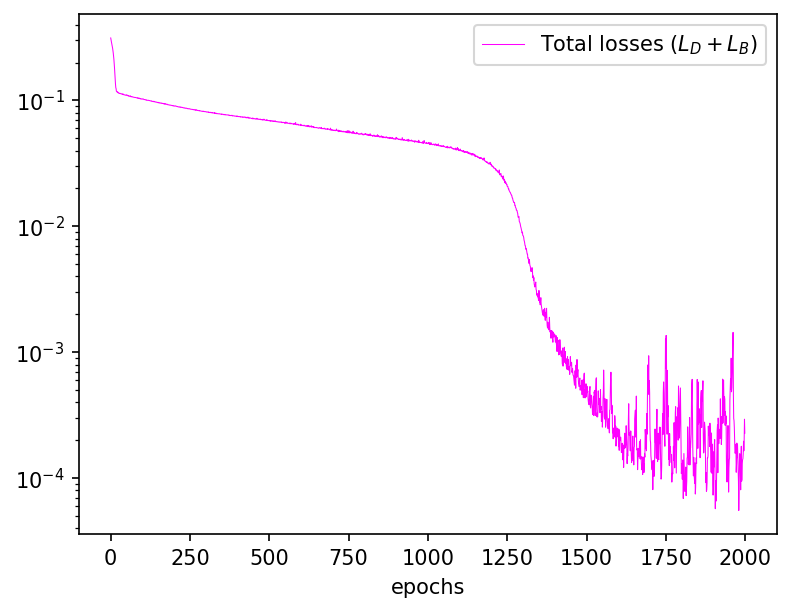

In [ ]:
# summarize history for loss and metris
plt.rcParams['figure.dpi'] = 150
plt.plot(history.history['loss'],color='magenta',linewidth=0.5,label='Total losses ($L_D + L_B$)')
#plt.plot(history.history['mean_squared_error'],color='cyan',linewidth=0.5,label='MSE')
plt.yscale("log")
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

### Visual check of the results

16/16 [==============================] - 0s 558us/step


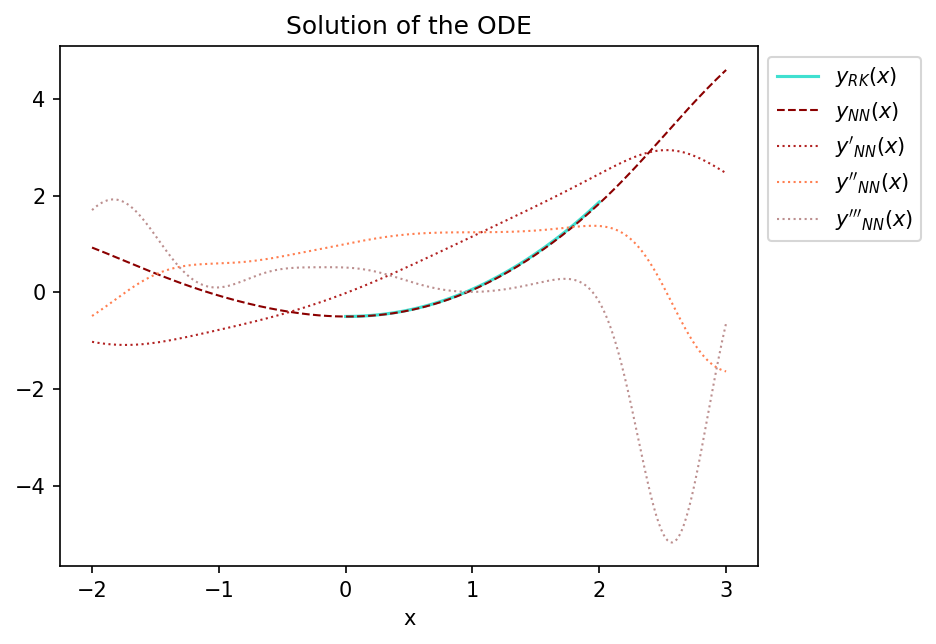

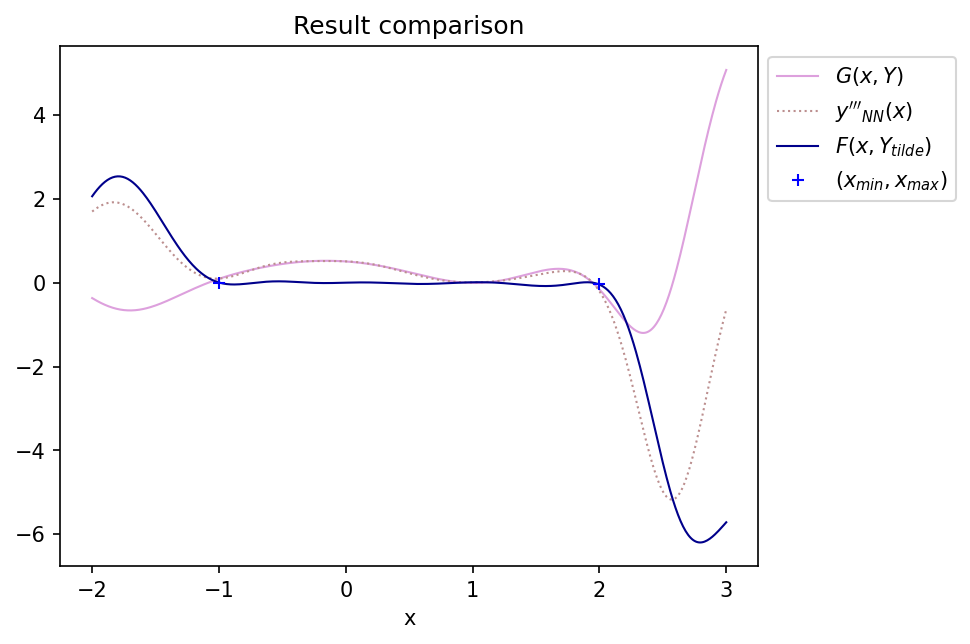

In [ ]:
# Check the PINN at different points not included in the training set
n = 500
x = np.linspace(xmin-1,xmax+1,n)
x0 = 0.0
y_NN = model.predict(x)

# We compute the derivatives and build Ytilde_NN again
x_tf = tf.convert_to_tensor(x, dtype=tf.float32)

with tf.GradientTape() as t1:  # persistent=True doesn't appear to be necessary
    t1.watch(x_tf)
    with tf.GradientTape() as t2:
        t2.watch(x_tf)
        with tf.GradientTape() as t3:
            t3.watch(x_tf)
            y_NN = model(x_tf)
        dy_dx_NN = t3.gradient(y_NN, x_tf)
    d2y_dx2_NN = t2.gradient(dy_dx_NN, x_tf)
d3y_dx3_NN = t1.gradient(d2y_dx2_NN, x_tf)

y_NN = tf.reshape(y_NN,dy_dx_NN.shape)
Ytilde_NN = tf.TensorArray(tf.float32, size=0, dynamic_size=True, clear_after_read=False)
Ytilde_NN = Ytilde_NN.write(0,y_NN)
Ytilde_NN = Ytilde_NN.write(1,dy_dx_NN)
if Order >= 2:
    Ytilde_NN = Ytilde_NN.write(2,d2y_dx2_NN)
if Order >= 3:
    Ytilde_NN = Ytilde_NN.write(3,d3y_dx3_NN)
Ytilde_NN = Ytilde_NN.stack()

# Define Graph parameters
colours = ("darkred","firebrick","coral","rosybrown")
linestyles = ("dashed","dotted","dotted","dotted")
labels = ("$y_{NN}(x)$","$y'_{NN}(x)$","$y''_{NN}(x)$","$y'''_{NN}(x)$")

# Plot the ODE solution
plt.rcParams['figure.dpi'] = 150
if RKsolvable:
    plt.plot(x_RK, Y_RK[:,0], color="turquoise", label="$y_{RK}(x)$")
for i in range(Order+1):
    plt.plot(x, Ytilde_NN[i], color=colours[i], linestyle=linestyles[i], linewidth=1, label=labels[i])
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.title("Solution of the ODE")
plt.xlabel("x")
plt.show()

# Check the ODE resolution
if RKsolvable:
    plt.plot(x, ode_G(x,Ytilde_NN[:-1]), color="plum", linewidth=1, label="$G(x,Y)$")
    plt.plot(x, Ytilde_NN[Order], color=colours[Order], linestyle=linestyles[Order], linewidth=1, label=labels[Order])
plt.plot(x, ode_F(x_tf,Ytilde_NN), color="darkblue", linewidth=1, label="$F(x,Y_{\t{tilde}})$")
plt.plot(xmin,ode_F(xmin,Ytilde_NN[:,np.where((x>=xmin))[0][0]]),'b+',label="$(x_{\t{min}},x_{\t{max}})$")
plt.plot(xmax,ode_F(xmax,Ytilde_NN[:,np.where((x<=xmax))[0][-1]]),'b+')
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.title("Result comparison")
plt.xlabel("x")
plt.show()

In the non-RKsolvable example the solution seems to jump to another one at around 1.2 . There is no other way to check the goodness of the solution but comparing $F$ to 0.